# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
import seaborn as sns
import matplotlib.dates as mdates
from dateutil import parser
import sys
import os
from sklearn.preprocessing import MinMaxScaler

# Dados Meteo

In [2]:
# Adiciona a pasta-pai ao sys.path (para importar meteorology)
sys.path.append(os.path.abspath(".."))
from meteorology.data.meteorology_data import GetMeteorologyData
df = GetMeteorologyData()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29973 entries, 0 to 29972
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          29973 non-null  datetime64[ns]
 1   temp              29973 non-null  float64       
 2   feelslike         29973 non-null  float64       
 3   dew               29973 non-null  float64       
 4   humidity          29973 non-null  float64       
 5   precip            28966 non-null  float64       
 6   precipprob        29973 non-null  float64       
 7   preciptype        804 non-null    object        
 8   windgust          2088 non-null   float64       
 9   windspeed         29966 non-null  float64       
 10  winddir           29790 non-null  float64       
 11  sealevelpressure  29973 non-null  float64       
 12  cloudcover        22653 non-null  float64       
 13  visibility        29967 non-null  float64       
 14  conditions        2997

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Selecionar só as colunas temp e precip e fazer o resample diário com média
df = df[['temp', 'precip']].resample('D').mean()


# Dados anomalias e contadores corrigidos

In [4]:
import sys
import os

# Adiciona a pasta-pai ao sys.path (para importar meteorology)
sys.path.append(os.path.abspath(".."))
from construcao_modelos.Mstl_contadores_todos import GetMSTL
df_anomalias_total = GetMSTL()


c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df_corrigido_final = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\construcao_modelos\df_corrigido_final.csv")


# Gini

In [6]:
def gini_covariancia(y):
    y = np.array(y)
    n = len(y)
    if n == 0 or np.sum(y) == 0:
        return np.nan

    y_sorted = np.sort(y)
    F_y = (np.arange(1, n + 1)) / n  # função de distribuição empírica (percentis)
    y_mean = np.mean(y_sorted)

    cov = np.cov(y_sorted, F_y, bias=True)[0, 1]  # covariância com bias=True para dividir por n
    gini = (2 * cov) / y_mean
    return gini

In [ ]:
def gini_cov_semanal(df, coluna='count_8', plotar=True, cor='blue'):
    df = df.copy()
    df = df.set_index('datetime')

    # Calcular Gini para cada semana com resample
    df_gini_cov = (
        df[coluna]
        .resample('W-MON')  # Semanas com início à segunda-feira
        .apply(gini_covariancia)
        .reset_index(name='gini')
    )

    if plotar:
        plt.figure(figsize=(14, 5))
        plt.plot(df_gini_cov['datetime'], df_gini_cov['gini'], marker='o', color=cor)
        plt.title('Índice de Gini cov semanal ')
        plt.xlabel('Data (início da semana)')
        plt.ylabel('Gini')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_gini_cov

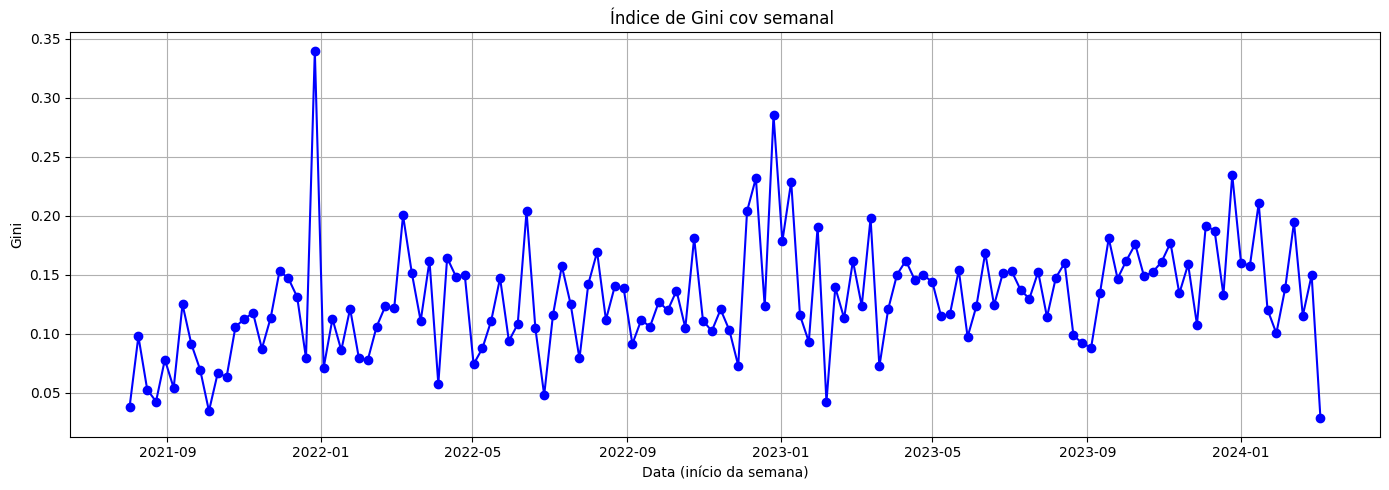

In [8]:
df_corrigido_final = df_corrigido_final.rename(columns={'detected': 'datetime'})
df_corrigido_final['datetime'] = pd.to_datetime(df_corrigido_final['datetime'])

df_gini_count8 = gini_cov_semanal(df_corrigido_final, coluna='count_8', plotar=True)


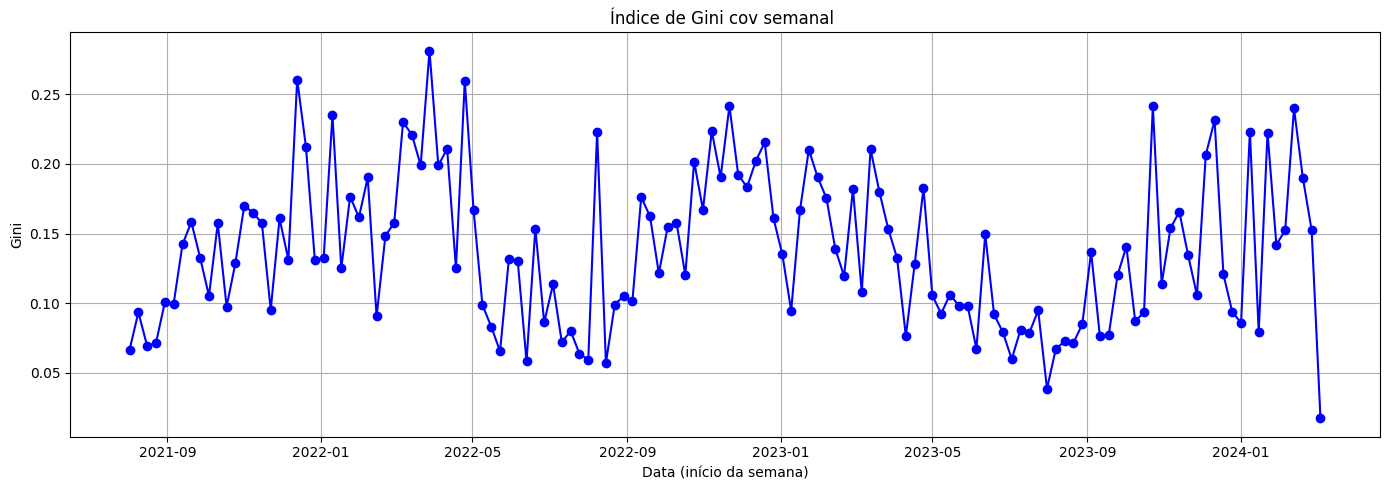

In [9]:
df_gini_count12 = gini_cov_semanal(df_corrigido_final, coluna='count_12', plotar=True)


# Gini + Meteo

### Juntar os dados num df

In [13]:
df.index = pd.to_datetime(df.index)
df_meteo_semanal = df.resample('W-MON').mean().reset_index()
df_meteo_semanal.columns = ['semana_data', 'temp', 'precip'] 

In [19]:
df_gini_count8.rename(columns={'datetime': 'semana_data'}, inplace=True)
df_gini_count12.rename(columns={'datetime': 'semana_data'}, inplace=True)

In [ ]:
df_meteo_semanal['semana_data'] = pd.to_datetime(df_meteo_semanal['semana_data'])
df_merged_count8 = pd.merge(df_gini_count8, df_meteo_semanal, on='semana_data', how='left')

In [ ]:
df_merged_count12 = pd.merge(df_gini_count12, df_meteo_semanal, on='semana_data', how='left')

### Gráficos Temperatura

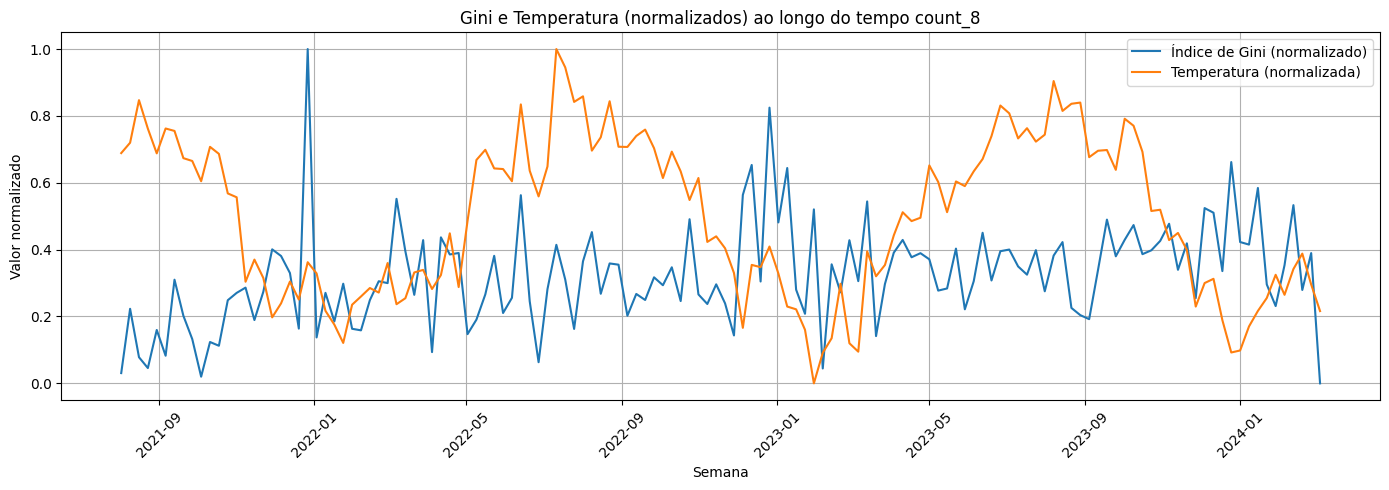

In [34]:

# Normalizar com min-max (0 a 1)
df_merged_count8['gini_norm'] = (df_merged_count8['gini'] - df_merged_count8['gini'].min()) / (df_merged_count8['gini'].max() - df_merged_count8['gini'].min())
df_merged_count8['temp_norm'] = (df_merged_count8['temp'] - df_merged_count8['temp'].min()) / (df_merged_count8['temp'].max() - df_merged_count8['temp'].min())

# Ordenar por semana para garantir a ordem temporal correta
df_sorted = df_merged_count8.sort_values('semana_data')

# Gráfico de linhas
plt.figure(figsize=(14,5))
plt.plot(df_sorted['semana_data'], df_sorted['gini_norm'], label='Índice de Gini (normalizado)')
plt.plot(df_sorted['semana_data'], df_sorted['temp_norm'], label='Temperatura (normalizada)')

plt.title('Gini e Temperatura (normalizados) ao longo do tempo count_8')
plt.xlabel('Semana')
plt.ylabel('Valor normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




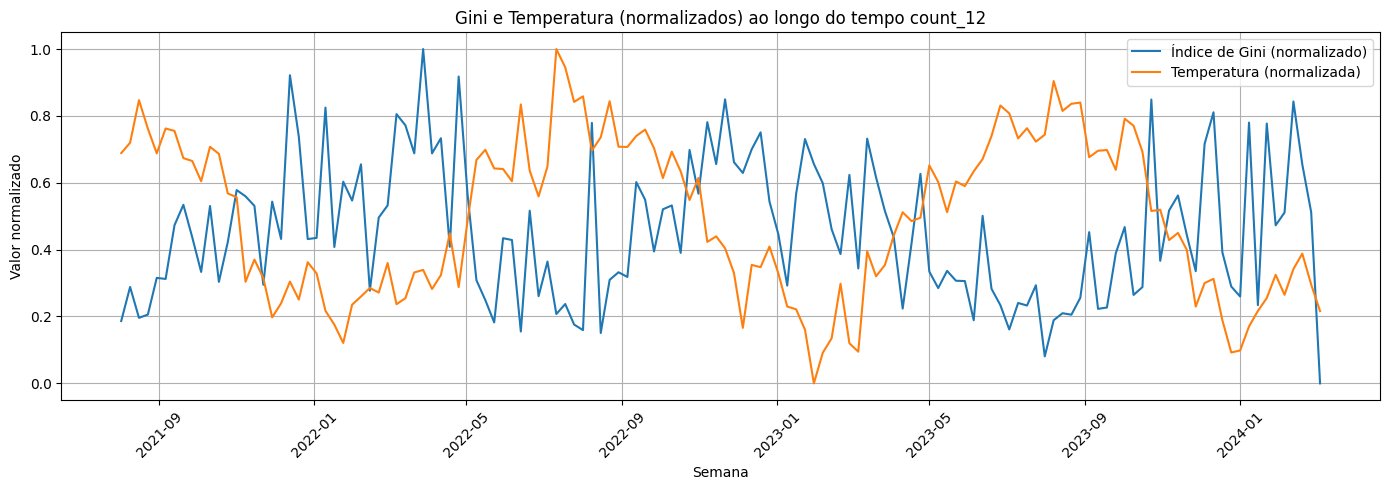

In [35]:
df_merged_count12['gini_norm'] = (df_merged_count12['gini'] - df_merged_count12['gini'].min()) / (df_merged_count12['gini'].max() - df_merged_count12['gini'].min())
df_merged_count12['temp_norm'] = (df_merged_count12['temp'] - df_merged_count12['temp'].min()) / (df_merged_count12['temp'].max() - df_merged_count12['temp'].min())

# Ordenar por semana para garantir a ordem temporal correta
df_sorted = df_merged_count12.sort_values('semana_data')

# Gráfico de linhas
plt.figure(figsize=(14,5))
plt.plot(df_sorted['semana_data'], df_sorted['gini_norm'], label='Índice de Gini (normalizado)')
plt.plot(df_sorted['semana_data'], df_sorted['temp_norm'], label='Temperatura (normalizada)')

plt.title('Gini e Temperatura (normalizados) ao longo do tempo count_12')
plt.xlabel('Semana')
plt.ylabel('Valor normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

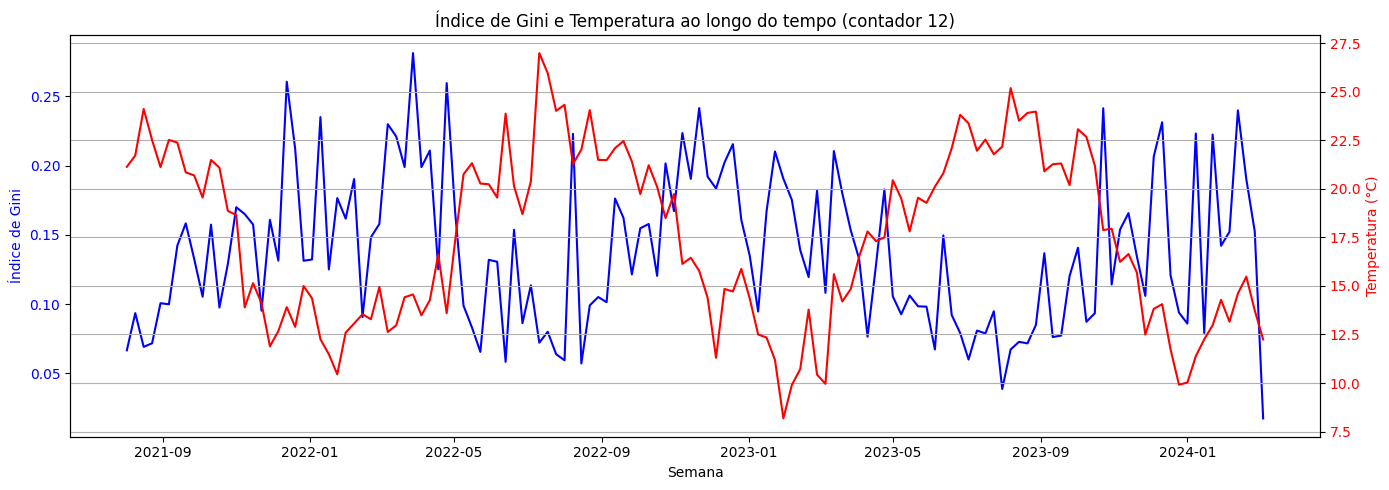

In [37]:
# Ordenar por semana para garantir a ordem temporal correta
df_sorted = df_merged_count12.sort_values('semana_data')

# Criar figura e eixo principal
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plotar o índice de Gini no eixo da esquerda
ax1.plot(df_sorted['semana_data'], df_sorted['gini'], color='blue', label='Índice de Gini')
ax1.set_xlabel('Semana')
ax1.set_ylabel('Índice de Gini', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Criar segundo eixo Y (compartilhando o eixo X)
ax2 = ax1.twinx()
ax2.plot(df_sorted['semana_data'], df_sorted['temp'], color='red', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título e layout
plt.title('Índice de Gini e Temperatura ao longo do tempo (contador 12)')
fig.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


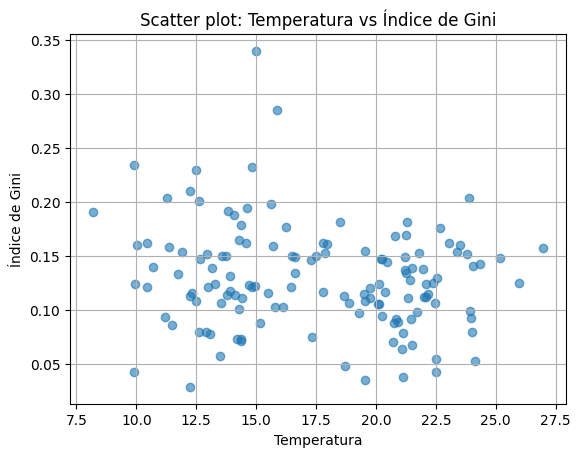

In [24]:
plt.scatter(df_merged_count8['temp'], df_merged_count8['gini'], alpha=0.6)

plt.title('Scatter plot: Temperatura vs Índice de Gini')
plt.xlabel('Temperatura')
plt.ylabel('Índice de Gini')
plt.grid(True)
plt.show()



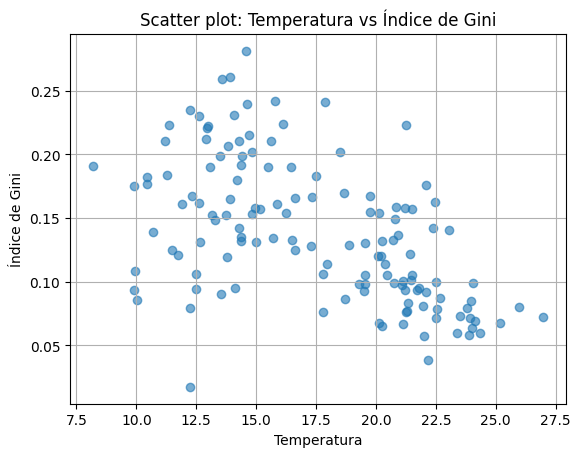

In [25]:
plt.scatter(df_merged_count12['temp'], df_merged_count12['gini'], alpha=0.6)

plt.title('Scatter plot: Temperatura vs Índice de Gini')
plt.xlabel('Temperatura')
plt.ylabel('Índice de Gini')
plt.grid(True)
plt.show()

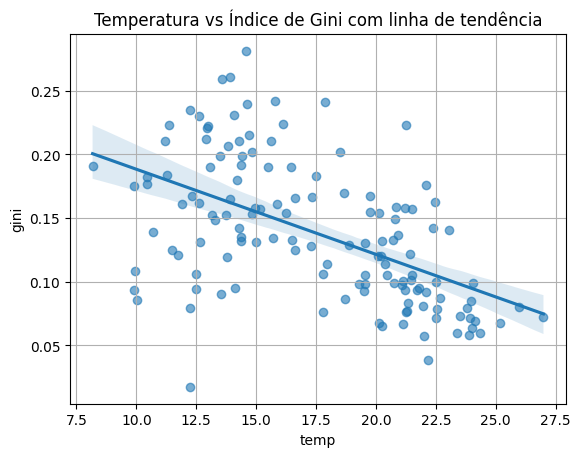

In [26]:
import seaborn as sns
sns.regplot(data=df_merged_count12, x='temp', y='gini', scatter_kws={'alpha':0.6})
plt.title('Temperatura vs Índice de Gini com linha de tendência')
plt.grid(True)
plt.show()


In [27]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(df_merged_count12['temp'], df_merged_count12['gini'])

print(f"Coeficiente de correlação de Pearson: {corr_coef:.4f}")
print(f"P-valor: {p_value:.4e}")

Coeficiente de correlação de Pearson: -0.5342
P-valor: 2.1260e-11


In [29]:
from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(df_merged_count8['temp'], df_merged_count8['gini'])

print(f"Coeficiente de correlação de Pearson: {corr_coef:.4f}")
print(f"P-valor: {p_value:.4e}")

Coeficiente de correlação de Pearson: -0.1640
P-valor: 5.6470e-02


### Graficos Precipitação

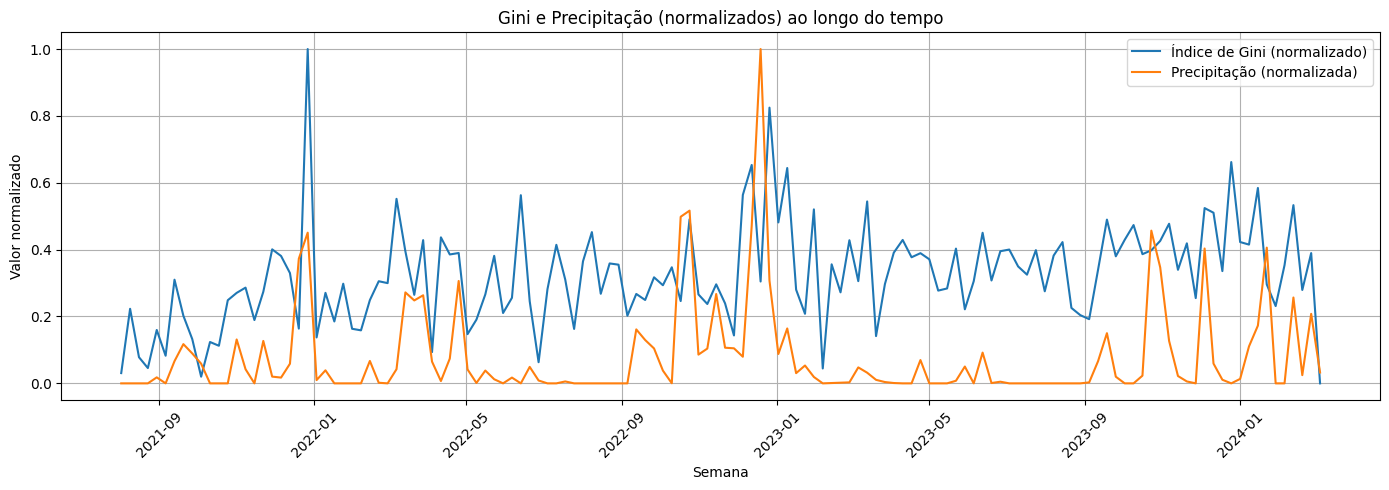

In [30]:
# Normalizar com min-max (0 a 1)
df_merged_count8['gini_norm'] = (df_merged_count8['gini'] - df_merged_count8['gini'].min()) / (df_merged_count8['gini'].max() - df_merged_count8['gini'].min())
df_merged_count8['precip_norm'] = (df_merged_count8['precip'] - df_merged_count8['precip'].min()) / (df_merged_count8['precip'].max() - df_merged_count8['precip'].min())

# Ordenar por semana para garantir a ordem temporal correta
df_sorted = df_merged_count8.sort_values('semana_data')

# Gráfico de linhas
plt.figure(figsize=(14,5))
plt.plot(df_sorted['semana_data'], df_sorted['gini_norm'], label='Índice de Gini (normalizado)')
plt.plot(df_sorted['semana_data'], df_sorted['precip_norm'], label='Precipitação (normalizada)')

plt.title('Gini e Precipitação (normalizados) ao longo do tempo')
plt.xlabel('Semana')
plt.ylabel('Valor normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

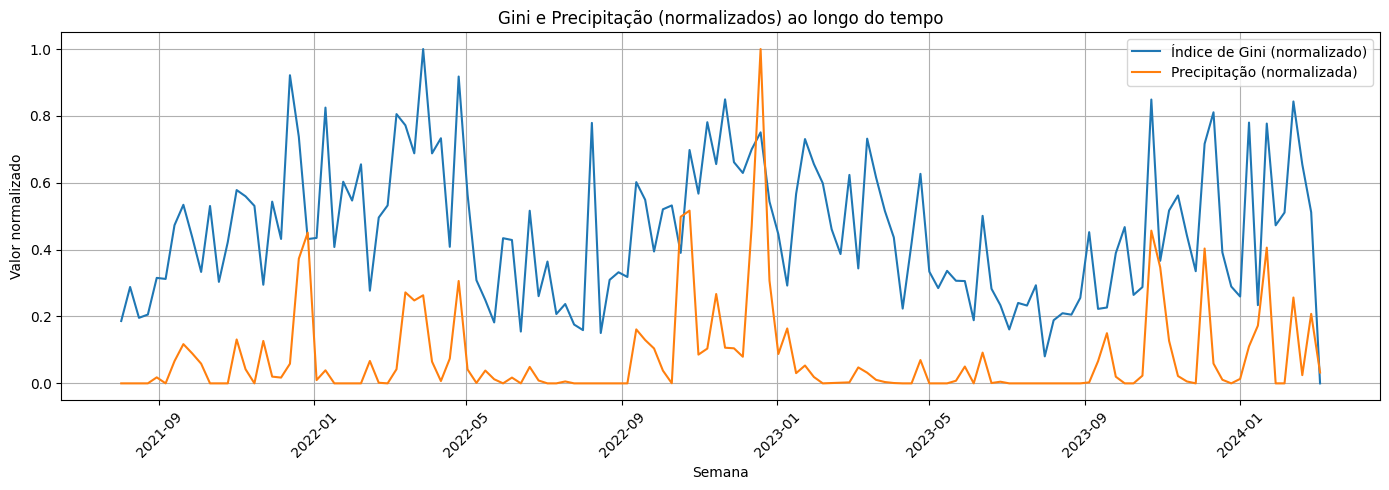

In [31]:
# Normalizar com min-max (0 a 1)
df_merged_count12['gini_norm'] = (df_merged_count12['gini'] - df_merged_count12['gini'].min()) / (df_merged_count12['gini'].max() - df_merged_count12['gini'].min())
df_merged_count12['precip_norm'] = (df_merged_count12['precip'] - df_merged_count12['precip'].min()) / (df_merged_count12['precip'].max() - df_merged_count12['precip'].min())

# Ordenar por semana para garantir a ordem temporal correta
df_sorted = df_merged_count12.sort_values('semana_data')

# Gráfico de linhas
plt.figure(figsize=(14,5))
plt.plot(df_sorted['semana_data'], df_sorted['gini_norm'], label='Índice de Gini (normalizado)')
plt.plot(df_sorted['semana_data'], df_sorted['precip_norm'], label='Precipitação (normalizada)')

plt.title('Gini e Precipitação (normalizados) ao longo do tempo')
plt.xlabel('Semana')
plt.ylabel('Valor normalizado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

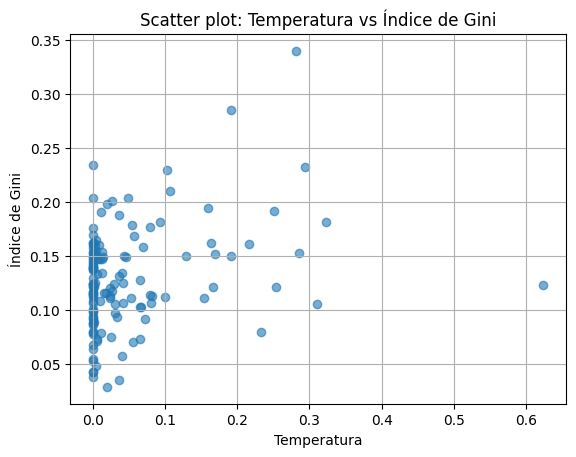

In [32]:
plt.scatter(df_merged_count8['precip'], df_merged_count8['gini'], alpha=0.6)

plt.title('Scatter plot: Temperatura vs Índice de Gini')
plt.xlabel('Temperatura')
plt.ylabel('Índice de Gini')
plt.grid(True)
plt.show()

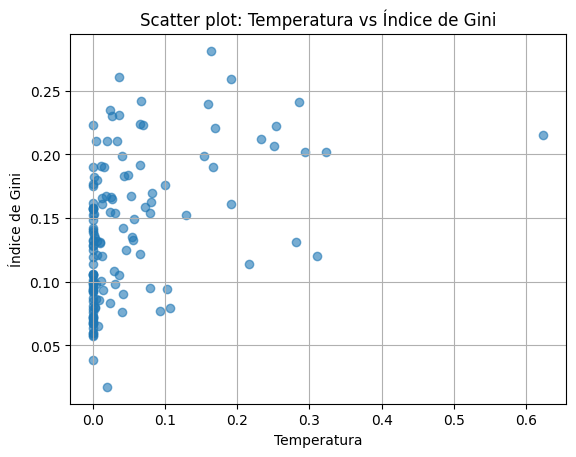

In [33]:
plt.scatter(df_merged_count12['precip'], df_merged_count12['gini'], alpha=0.6)

plt.title('Scatter plot: Temperatura vs Índice de Gini')
plt.xlabel('Temperatura')
plt.ylabel('Índice de Gini')
plt.grid(True)
plt.show()